In [ ]:
import numpy as np
import galax.potential as gp
import jax.numpy as jnp
import optax
import jax
import matplotlib.pyplot as plt

from galactoPINNs.data import generate_static_datadict, scale_data, generate_xy_plane_grid
from galactoPINNs.models.static_model import StaticModel
from galactoPINNs.train import train_model_static
from galactoPINNs.model_potential import make_galax_potential
from galactoPINNs.evaluate import evaluate_performance


In [12]:
####
### Generate synthetic data for training and testing
####


true_MW_potential = gp.MilkyWayPotential()
true_lmc_potential = gp.NFWPotential(m=1.0e11, r_s=5.0, units="galactic")
lmc_center = jnp.array([50.0, 0.0, 0.0])  # in kpc
lmc_pot_centered = gp.TranslatedPotential(true_lmc_potential, translation=lmc_center)

true_potential = true_MW_potential + lmc_pot_centered
analytic_baseline_potential =  gp.NFWPotential(m= 5.4e11, r_s= 15.62, units="galactic")


In [ ]:
####
### Generate the training and testing sets
####

raw_datadict = generate_static_datadict(
    galax_potential=true_potential,
    N_samples_train = 2048,
    N_samples_test = 4096,
    r_max_train = 100,
    r_max_test = 150,
)

In [ ]:
####
### Nondimensionalize the data, and set up the model configuration
####

r_s = 15.62
include_analytic_baseline = True

scale_config = {
    "r_s": r_s,
    "include_analytic": True,
    "lf_analytic_function": analytic_baseline_potential
}

scaled_data, transformers = scale_data(
    raw_datadict, scale_config
)


train_config = {
    "x_transformer": transformers["x"],
    "a_transformer": transformers["a"],
    "u_transformer": transformers["u"],
    "r_s": r_s,
    "lf_analytic_function": analytic_baseline_potential,
    "include_analytic": True,
    "scale": "nfw",
    "depth": 6,
}


In [ ]:
####
### Define training hyperparameters
####

nepochs = 500
l_rel = 0.1
lr0 = 1e-3

lr_schedule_exp = optax.exponential_decay(
    init_value=lr0,
    transition_steps=2500,
    decay_rate=0.5,
)
optimizer_exp = optax.adam(lr_schedule_exp)


In [ ]:
####
### Initialize and train the model
####

net = StaticModel(train_config)
x_train = scaled_data["x_train"]
a_train = scaled_data["a_train"]


rng = jax.random.PRNGKey(0)
train_output = train_model_static(
        net, optimizer_exp, x_train, a_train, num_epochs=nepochs, lambda_rel=l_rel
    )


In [ ]:
####
### Evaluate the learned potential
####

learned_potential = make_galax_potential(net, train_output["state"].params)

/Users/charlottemyers/projects/GalactoPINNs/src/galactoPINNs/model_potential.py:133: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return ModelPotential(



In [16]:
####
### Set up evaluation grid in the x-y plane
####
xy_points = generate_xy_plane_grid(-70, 70, -70, 70, num_x=50, num_y=50) # in kpc
true_potential_xy = true_potential.potential(xy_points, t=0)  # in kpc^2/Myr^2
predicted_potential_xy = learned_potential.potential(xy_points, t=0)

true_acc_xy = true_potential.acceleration(xy_points, t=0)  # in kpc/Myr^2
predicted_acc_xy = learned_potential.acceleration(xy_points, t=0)

<>:23: SyntaxWarning: invalid escape sequence '\p'

<>:29: SyntaxWarning: invalid escape sequence '\p'

<>:23: SyntaxWarning: invalid escape sequence '\p'

<>:29: SyntaxWarning: invalid escape sequence '\p'

/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_76372/1872962072.py:23: SyntaxWarning: invalid escape sequence '\p'
  axs[0].set_title("True $\phi$")

/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_76372/1872962072.py:29: SyntaxWarning: invalid escape sequence '\p'
  axs[1].set_title("Predicted $\phi$")



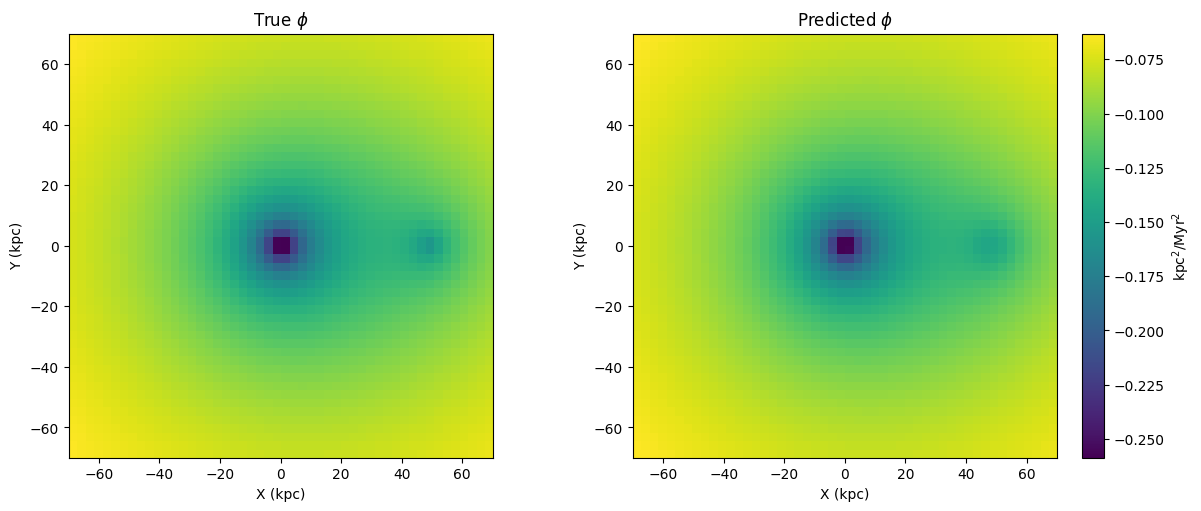

In [ ]:
####
### Visualize the results
####

nx = ny = int(jnp.sqrt(len(xy_points)))
x = xy_points[:, 0].reshape((ny, nx))
y = xy_points[:, 1].reshape((ny, nx))

true_u = true_potential_xy.reshape((ny, nx))
pred_u = predicted_potential_xy.reshape((ny, nx))

vmin = jnp.min(true_u)
vmax = jnp.max(true_u)


############

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

im0 = axs[0].imshow(true_u, origin="lower", extent=[x.min(), x.max(), y.min(), y.max()],
                    cmap="viridis", vmin=vmin, vmax=vmax)

axs[0].set_title("True $\phi$")
axs[0].set_xlabel("X (kpc)")
axs[0].set_ylabel("Y (kpc)")

im1 = axs[1].imshow(pred_u, origin="lower", extent=[x.min(), x.max(), y.min(), y.max()],
                    cmap="viridis", vmin=vmin, vmax=vmax)
axs[1].set_title("Predicted $\phi$")
axs[1].set_xlabel("X (kpc)")
axs[1].set_ylabel("Y (kpc)")
plt.colorbar(im1, ax=axs[1], label="kpc$^2$/Myr$^2$")
plt.show()
